In [98]:
from tensorflow import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [2]:
image_size = 80
batch_size = 32
channels = 3
epochs = 100

In [3]:
dataset = keras.preprocessing.image_dataset_from_directory(
    'seg_train', 
    shuffle = True,
    batch_size = batch_size,
    image_size = (image_size, image_size)
)

Found 17034 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [5]:
len(dataset)

533

In [6]:
for image, label in dataset.take(1):
    print(image.shape)
    print(label.numpy())

(32, 80, 80, 3)
[5 4 1 2 3 0 0 0 3 1 5 5 3 2 2 2 0 4 2 5 0 4 3 0 4 0 3 2 1 3 3 5]


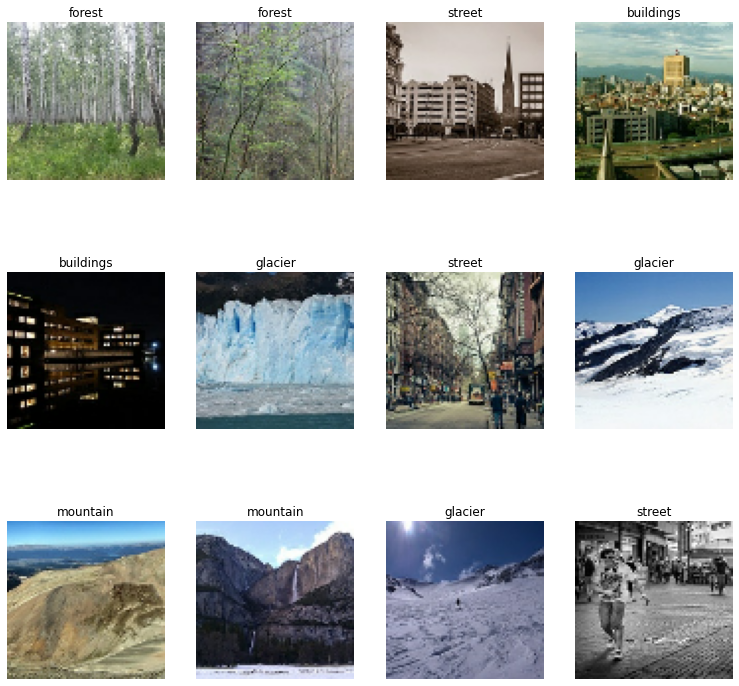

In [7]:
plt.figure(figsize = (13, 13))
for image, label in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i].numpy()])
        plt.axis('off')

In [8]:
def splitting_data(data):
    train_size = int(0.8 * len(data))
    test_size = int(0.1 * len(data))
    validation_size = int(0.1 * len(data))
    train_ds = data.take(train_size)
    test_ds = data.skip(train_size).take(test_size)
    validation_ds = data.skip(train_size + test_size).take(validation_size)
    return train_ds, test_ds, validation_ds

In [9]:
train_data, test_data, validation_data = splitting_data(dataset)

In [10]:
len(train_data)

426

In [11]:
len(test_data)

53

In [12]:
len(validation_data)

53

In [13]:
train_data = train_data.map(lambda x, y:(x / 255, y))

In [14]:
for image, label in train_data.take(1):
    print(image[0].numpy())
    print(label.numpy())

[[[0.12254902 0.14833027 0.13189338]
  [0.14466912 0.17254902 0.1481005 ]
  [0.13814338 0.17809436 0.14672181]
  ...
  [0.08538603 0.0893076  0.09715074]
  [0.1078125  0.11173407 0.11957721]
  [0.08089767 0.08874081 0.08481924]]

 [[0.1153799  0.15479474 0.14269301]
  [0.12170649 0.16029412 0.14730392]
  [0.13170956 0.17484681 0.15330882]
  ...
  [0.10202206 0.10594363 0.1216299 ]
  [0.10442708 0.10834865 0.11619179]
  [0.08224571 0.09008885 0.08616728]]

 [[0.16161151 0.19217218 0.19656862]
  [0.15618873 0.18704045 0.19240196]
  [0.18094362 0.21444547 0.20992647]
  ...
  [0.12930453 0.13543199 0.15038297]
  [0.10030637 0.10422794 0.11207108]
  [0.09076287 0.09860601 0.09468444]]

 ...

 [[0.56026345 0.5335478  0.4943321 ]
  [0.48184744 0.4546722  0.40044424]
  [0.44394913 0.45151654 0.3628217 ]
  ...
  [0.476731   0.4619179  0.42621017]
  [0.52515316 0.50456494 0.48154107]
  [0.5229626  0.504182   0.4880821 ]]

 [[0.51053923 0.48072916 0.45053616]
  [0.58507967 0.5472273  0.51557904]


In [15]:
test_data = test_data.map(lambda x, y: (x / 255, y))

In [16]:
validation_data = validation_data.map(lambda x, y: (x / 255, y))

In [17]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_data = validation_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [25]:
data_augmentation = Sequential([
    layers.RandomContrast(factor = 0.2, input_shape = (image_size, image_size, channels)),
    layers.RandomZoom(height_factor = (0.2, 0.3)),
])

In [26]:
model = Sequential()

In [27]:
model.add(data_augmentation)
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation = 'softmax'))

In [28]:
model.compile(
    optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['accuracy']
)

In [29]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 4)

In [31]:
history = model.fit(train_data, epochs = epochs, validation_data = validation_data, callbacks = [early_stopping],
                   batch_size = batch_size, verbose = 1)

Epoch 1/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 131s 303ms/step - accuracy: 0.4182 - loss: 1.3985 - val_accuracy: 0.5967 - val_loss: 1.0548
Epoch 2/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 132s 309ms/step - accuracy: 0.6348 - loss: 0.9491 - val_accuracy: 0.6427 - val_loss: 0.8903
Epoch 3/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 136s 319ms/step - accuracy: 0.6896 - loss: 0.8252 - val_accuracy: 0.7429 - val_loss: 0.7047
Epoch 4/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 142s 333ms/step - accuracy: 0.7425 - loss: 0.7238 - val_accuracy: 0.7877 - val_loss: 0.5879
Epoch 5/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 135s 317ms/step - accuracy: 0.7675 - loss: 0.6355 - val_accuracy: 0.7907 - val_loss: 0.5698
Epoch 6/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 134s 314ms/step - accuracy: 0.7954 - loss: 0.5655 - val_accuracy: 0.7978 - val_loss: 0.5661
Epoch 7/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 132s 310ms/step - accuracy: 0.8121 - loss: 0.5332 - val_accuracy: 0.8302 - val_loss: 0.4815
Epoch 8/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 132s 310ms/step - accuracy: 

In [32]:
model.evaluate(test_data)

53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.8377 - loss: 0.4906


[0.47331348061561584, 0.8402122855186462]

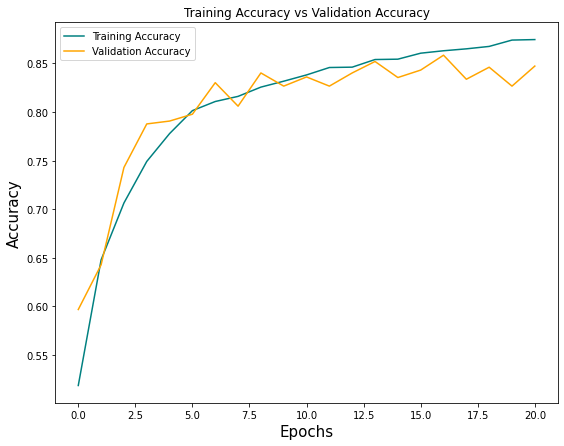

In [33]:
plt.figure(figsize = (9, 7))
plt.plot(history.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.show()

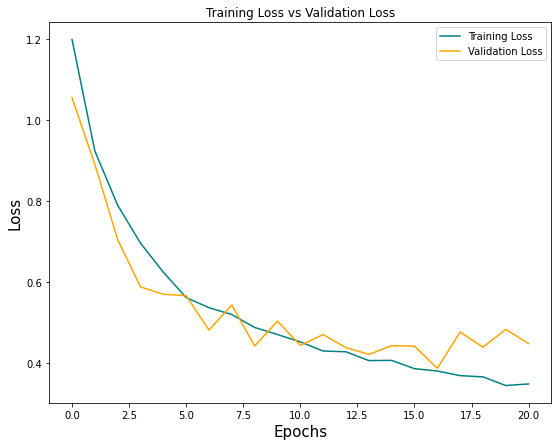

In [35]:
plt.figure(figsize = (9, 7))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend()
plt.show()

In [39]:
X_test = []
y_test = []
for images, labels in test_data:
    for image in images:
        X_test.append(image.numpy())
    for label in labels:
        y_test.append(label.numpy())

In [41]:
X_test[0]

array([[[0.51590073, 0.5472733 , 0.63596815],
        [0.5463848 , 0.57775736, 0.659038  ],
        [0.570818  , 0.598269  , 0.6724571 ],
        ...,
        [0.6364277 , 0.66420037, 0.7259804 ],
        [0.6071844 , 0.6346354 , 0.69738054],
        [0.6612898 , 0.6887408 , 0.7514859 ]],

       [[0.50062805, 0.5437653 , 0.6235754 ],
        [0.3776348 , 0.42077205, 0.49675244],
        [0.4928615 , 0.5279565 , 0.6       ],
        ...,
        [0.66208637, 0.7013021 , 0.7479013 ],
        [0.67879903, 0.7180147 , 0.76507354],
        [0.5372549 , 0.57254905, 0.6313726 ]],

       [[0.44512868, 0.49397978, 0.58581495],
        [0.4275582 , 0.47561276, 0.55991113],
        [0.5381434 , 0.5873315 , 0.66303617],
        ...,
        [0.5476869 , 0.59866726, 0.6339614 ],
        [0.63481927, 0.6818781 , 0.7289369 ],
        [0.5135263 , 0.5605852 , 0.61548716]],

       ...,

       [[0.3925092 , 0.43564644, 0.51407784],
        [0.3775582 , 0.42069545, 0.49912685],
        [0.43221506, 0

In [43]:
y_test[:10]

[3, 1, 4, 0, 0, 5, 4, 1, 1, 3]

In [47]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [48]:
X_test.shape

(1696, 80, 80, 3)

In [49]:
len(y_test)

1696

In [50]:
y_pred = model.predict(X_test)
y_pred[:10]

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step


array([[1.7115680e-04, 1.1455812e-06, 8.9617306e-01, 1.0119164e-01,
        1.6118480e-03, 8.5110450e-04],
       [2.2442705e-07, 9.9994862e-01, 4.9771803e-05, 6.5976559e-07,
        7.1462824e-07, 3.6497825e-09],
       [3.6350364e-04, 4.2605381e-03, 3.0967563e-02, 7.4687433e-01,
        1.9356036e-01, 2.3973642e-02],
       [9.0803772e-01, 6.9179109e-06, 6.1646150e-04, 2.5637576e-03,
        1.0537374e-03, 8.7721318e-02],
       [4.1172591e-01, 5.6817329e-01, 4.7640339e-04, 8.9422647e-06,
        2.4417572e-04, 1.9371320e-02],
       [1.6454510e-01, 1.3416780e-03, 2.0638413e-03, 7.0185651e-04,
        1.8226932e-03, 8.2952476e-01],
       [1.9893234e-03, 2.6843217e-04, 1.2428802e-02, 5.1178834e-03,
        9.7794193e-01, 2.2536085e-03],
       [5.1186066e-06, 9.9992204e-01, 6.7831759e-05, 3.6755143e-06,
        7.1253510e-07, 5.7877054e-07],
       [8.1385649e-04, 9.7954708e-01, 1.5456433e-02, 2.1609284e-03,
        1.2675102e-03, 7.5408886e-04],
       [3.6452309e-04, 9.5004611e-07,

In [51]:
y_predict = [np.argmax(i) for i in y_pred]
y_predict[:10]

[2, 1, 3, 0, 1, 5, 4, 1, 1, 2]

In [52]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       259
           1       0.92      0.97      0.94       280
           2       0.79      0.79      0.79       319
           3       0.74      0.80      0.77       281
           4       0.90      0.78      0.83       260
           5       0.89      0.87      0.88       297

    accuracy                           0.84      1696
   macro avg       0.84      0.84      0.84      1696
weighted avg       0.84      0.84      0.84      1696



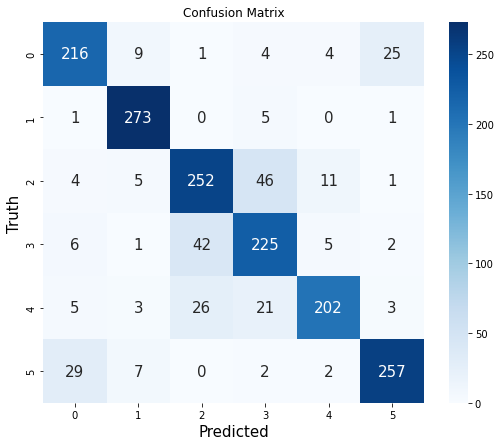

In [53]:
plt.figure(figsize = (9, 7))
sns.heatmap(confusion_matrix(y_test, y_predict), annot = True, square = True, cbar = True, annot_kws = {'size' : 15}, fmt = 'd',
           cmap = 'Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Truth', fontsize = 15)
plt.show()